> <h2>Module initialization</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

> <h2>Parsing initialization</h2>

Define the name of the dataset file

In [2]:
file = "dataset.csv"

Read and parse the file

In [3]:
df = pd.read_csv(file, sep=";")

Remove duplicate rows

In [4]:
df_clean = df.drop_duplicates().copy()

> <h2>Utils</h2>

Similar word function (finds the word in the list closest to the given word)

In [5]:
def similar_word(word=str, list_words=list):
    same_letter = []
    maxi = 0
    index = 0
    for i in range(len(list_words)):
        same_letter.append(0)
    ind = 0
    for w in list_words:
        for i in range(min(len(word), len(w))):
            if word[i] == w[i]:
                same_letter[ind] += 1
        ind += 1
    for enum, nb in enumerate(same_letter):
        if nb > maxi:
            maxi = nb
            index = enum
    return str(list_words[index])

> <h2>Cleanning</h2>

Fix correct names of the stations with some recurrence tolerance
- **station_counts** contains the number of recurrences of each station using **.value_counts()**
- **good_stations** contains only the correct stations
- **.index** transforms Boulean values ​​through their labels
- **.tolist()** transforms the return dataframe into a list

In [6]:
tolerance = 10
station_counts = df_clean["Departure station"].value_counts()
good_stations = station_counts[station_counts > tolerance].index.tolist()

Reformatting wrong dates
- **.mode()[0]** returns the most frequent date in the column **Date**
- **pd.to_datetime()** transform type of column **Date** into **Datetime[64]**
- **.fillna(most_use_date)** replace all the *missing values* into the most use date in column **Date**

In [7]:
most_use_date = df_clean["Date"].mode()[0]
df_clean["Date"] = pd.to_datetime(df_clean["Date"], format="%Y-%m", errors="coerce")
df_clean["Date"] = df_clean["Date"].fillna(most_use_date)

Remove lines with duplicates date, departure station and arrival stations
- **subset** specifies the columns on which **drop_duplicates()** looks for duplicates

In [8]:
df_clean = df_clean.drop_duplicates(
    subset=["Date", "Departure station", "Arrival station"]
).copy()

Add column **Year** in DataFrame
- **.dt.year** only returns the year of the date in the **Date** column

In [9]:
df_clean["Year"] = df_clean["Date"].dt.year

Rename wrong Service
- look at the services that are not in **services** and replace them with the closest service or with the most frequent service if their are *missing value*
- **.apply()** applies the changes to all rows in the column

In [10]:
services = ["National", "International"]
df_clean["Service"] = df_clean["Service"].apply(
    lambda service: service
    if (service == "National" or service == "International")
    else (
        df_clean["Service"].mode()[0]
        if pd.isna(service)
        else similar_word(service, services)
    )
)

Rename wrong stations
- **.dropna()** delete rows with *missing value*
- **subset** tells dropna to only look at the specified columns
- **how="any"** specifies that the row is deleted if **one or more** of the two values ​​in the specified columns is a *missing value*

In [11]:
df_clean = df_clean.dropna(subset=["Departure station", "Arrival station"], how="any")
df_clean["Departure station"] = df_clean["Departure station"].apply(
    lambda station: station
    if station in good_stations
    else similar_word(station, good_stations)
)
df_clean["Arrival station"] = df_clean["Arrival station"].apply(
    lambda station: station
    if station in good_stations
    else similar_word(station, good_stations)
)

**col_to_numeric** is the array containing all the columns of the dataframe whose type will be converted to **float**

In [12]:
col_to_numeric = [
    "Number of scheduled trains",
    "Number of cancelled trains",
    "Number of trains delayed at departure",
    "Number of trains delayed at arrival",
    "Number of trains delayed > 15min",
    "Number of trains delayed > 30min",
    "Number of trains delayed > 60min",
    "Average journey time",
    "Average delay of late trains at departure",
    "Average delay of all trains at departure",
    "Average delay of late trains at arrival",
    "Average delay of all trains at arrival",
    "Average delay of trains > 15min (if competing with flights)",
    "Pct delay due to external causes",
    "Pct delay due to infrastructure",
    "Pct delay due to traffic management",
    "Pct delay due to rolling stock",
    "Pct delay due to station management and equipment reuse",
    "Pct delay due to passenger handling (crowding, disabled persons, connections)",
]

Convert columns to appropriate types
- **pd.to_numeric** transforms type into **float[64]**
- **.astype()** transforms type into the specified type
- **errors="coerce"** transforms wrong values into *missing value*
- **.groupby()** groups data by **specified column(s)**
- **.mean()** returns the average of the data
- **.merge()** combines two **DataFrames**
- **.reset_index()** remove changes from the **groupby()** instruction
- **.isna()** allows you to know if the value is a *missing value*
- **.loc[]** allows **access or modification** of rows/columns based on **labels or conditions**

> <h2>Conversions</h2>

Convert all numerical columns to numeric numbers
- **pd.to_numeric** transforms type into **float[64]**

In [13]:
df_clean[col_to_numeric] = df_clean[col_to_numeric].apply(
    pd.to_numeric, errors="coerce"
)
df_clean = df_clean.dropna(subset=col_to_numeric[:7])

Converting strings columns to appropriate types
- **.astype()** transforms type into the specified type

In [14]:
df_clean["Service"] = df_clean["Service"].astype("category")
df_clean["Departure station"] = df_clean["Departure station"].astype("string")
df_clean["Arrival station"] = df_clean["Arrival station"].astype("string")

Add column **Average delays** in DataFrame
- **.groupby()** groups data by **specified column(s)**
- **.mean()** returns the average of the data
- **.merge()** combines two **DataFrames**
- **.reset_index()** remove changes from the **groupby()** instruction

In [15]:
delays_mean = df_clean.groupby(["Departure station", "Arrival station"])[
    [
        "Average delay of late trains at departure",
        "Average delay of late trains at arrival",
    ]
].mean()
delays_mean["Average delays"] = delays_mean.mean(axis=1)

df_clean = df_clean.merge(
    delays_mean["Average delays"].reset_index(),
    on=["Departure station", "Arrival station"],
    how="left",
)

Remove missing values from **averages columns**
- **.isna()** allows you to know if the value is a *missing value*

In [16]:
for column in col_to_numeric[:13]:
    not_good_number = (df_clean[column].isna()) | (df_clean[column] < 0)
    journey_mean = df_clean.groupby(["Departure station", "Arrival station"])[
        column
    ].transform("mean")
    means = df_clean[column].mean()
    df_clean.loc[not_good_number, column] = journey_mean[not_good_number]
    df_clean[column] = df_clean[column].fillna(means)

Replace wrong percentages into **average delays**
- **.loc[]** allows **access or modification** of rows/columns based on **labels or conditions**

In [17]:
for column in col_to_numeric[13:]:
    condition = (df_clean[column] > 100) | (
        df_clean[column] == 0 | pd.isna(df_clean[column])
    )
    df_clean.loc[condition, column] = df_clean.loc[condition, "Average delays"]

Replace **all comments** with empty strings (*comments are not used*)

In [18]:
comment_columns = [
    "Cancellation comments",
    "Departure delay comments",
    "Arrival delay comments",
]
df_clean[comment_columns] = df_clean[comment_columns].astype("string")
df_clean.loc[:, comment_columns] = ""

> <h2>Generation</h2>

Generation of the **new clean dataset**
- **.to_csv** convert DataFrame into **.csv file**

In [19]:
df_clean.to_csv("cleaned_dataset.csv")

---

<h2>Visualization</h2>

Creating graph **display functions**

In [20]:
def display_bar_graph(
    lst=list, labels=list, axis=str, title=str, size: tuple = None, rotation: int = None
):
    if size is None:
        size = (10, 20)
    if rotation is None:
        rotation = 60
    plt.figure(figsize=size)
    plt.title(title)
    plt.grid(True)
    if axis == "x":
        plt.bar(labels, lst)
        plt.ylabel("Number of trains")
        plt.xticks(rotation=rotation)
    elif axis == "y":
        plt.barh(labels, lst)
        plt.xlabel("Number of trains")
    else:
        print("The axis argument must be either 'x' or 'y'.")
        return
    plt.show()


def display_double_bar_graph(
    lst1=list,
    lst2=list,
    labels=list,
    axis=str,
    title=str,
    size: tuple = None,
    rotation: int = None,
):
    x = np.arange(len(labels))
    largeur = 0.35
    if size is None:
        size = (10, 20)
    if rotation is None:
        rotation = 60
    _, ax = plt.subplots(figsize=size)
    if axis == "x":
        ax.bar(x - largeur / 2, lst1, largeur, label="Scheduled")
        ax.bar(x - largeur / 2, lst2, largeur, label="Delayed/Cancelled")
    elif axis == "y":
        ax.barh(x - largeur / 2, lst1, largeur, label="Scheduled")
        ax.barh(x - largeur / 2, lst2, largeur, label="Delayed/Cancelled")
    else:
        print("The axis argument must be either 'x' or 'y'.")
        return
    ax.set_ylabel("Number of trains")
    ax.set_title(title)
    if axis == "x":
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=rotation)
    elif axis == "y":
        ax.set_yticks(x)
        ax.set_yticklabels(labels)
    ax.legend()
    ax.grid(True, axis="y", zorder=0)
    plt.show()


def display_pie_graph(lst=list, labels=list, title=str):
    plt.title(title)
    plt.xlabel("Number of trains")
    plt.pie(lst, autopct="%.1f%%")
    plt.legend(
        labels, title="Cause of delay", loc="upper right", bbox_to_anchor=(0, 0.8)
    )
    plt.show()

Number of delayed trains by **(> 15 min), (> 30 min), (> 60 min)**

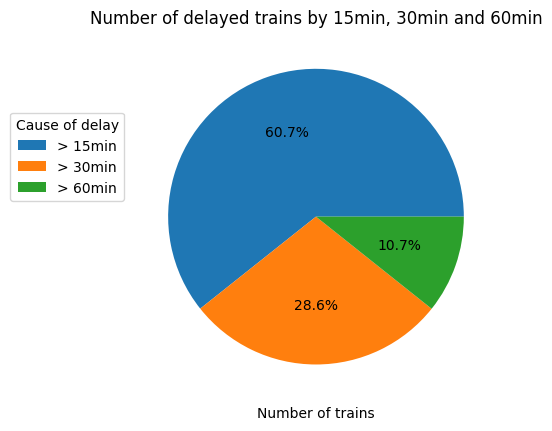

In [21]:
title = "Number of delayed trains by 15min, 30min and 60min"
labels = ["> 15min", "> 30min", "> 60min"]
lst = [
    df_clean["Number of trains delayed > 15min"].sum(),
    df_clean["Number of trains delayed > 30min"].sum(),
    df_clean["Number of trains delayed > 60min"].sum(),
]
display_pie_graph(lst, labels, title)

Delay distribution by **percentage**

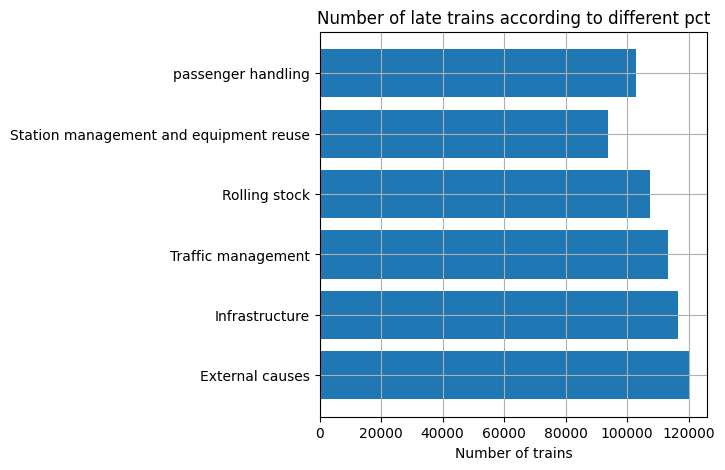

In [22]:
title = "Number of late trains according to different pct"
labels = [
    "External causes",
    "Infrastructure",
    "Traffic management",
    "Rolling stock",
    "Station management and equipment reuse",
    "passenger handling",
]
lst = [
    df_clean["Pct delay due to external causes"].sum(),
    df_clean["Pct delay due to infrastructure"].sum(),
    df_clean["Pct delay due to traffic management"].sum(),
    df_clean["Pct delay due to rolling stock"].sum(),
    df_clean["Pct delay due to station management and equipment reuse"].sum(),
    df_clean[
        "Pct delay due to passenger handling (crowding, disabled persons, connections)"
    ].sum(),
]
display_bar_graph(lst, labels, "y", title, (5, 5))

Number of trains **delayed or cancelled** at **departure by station**

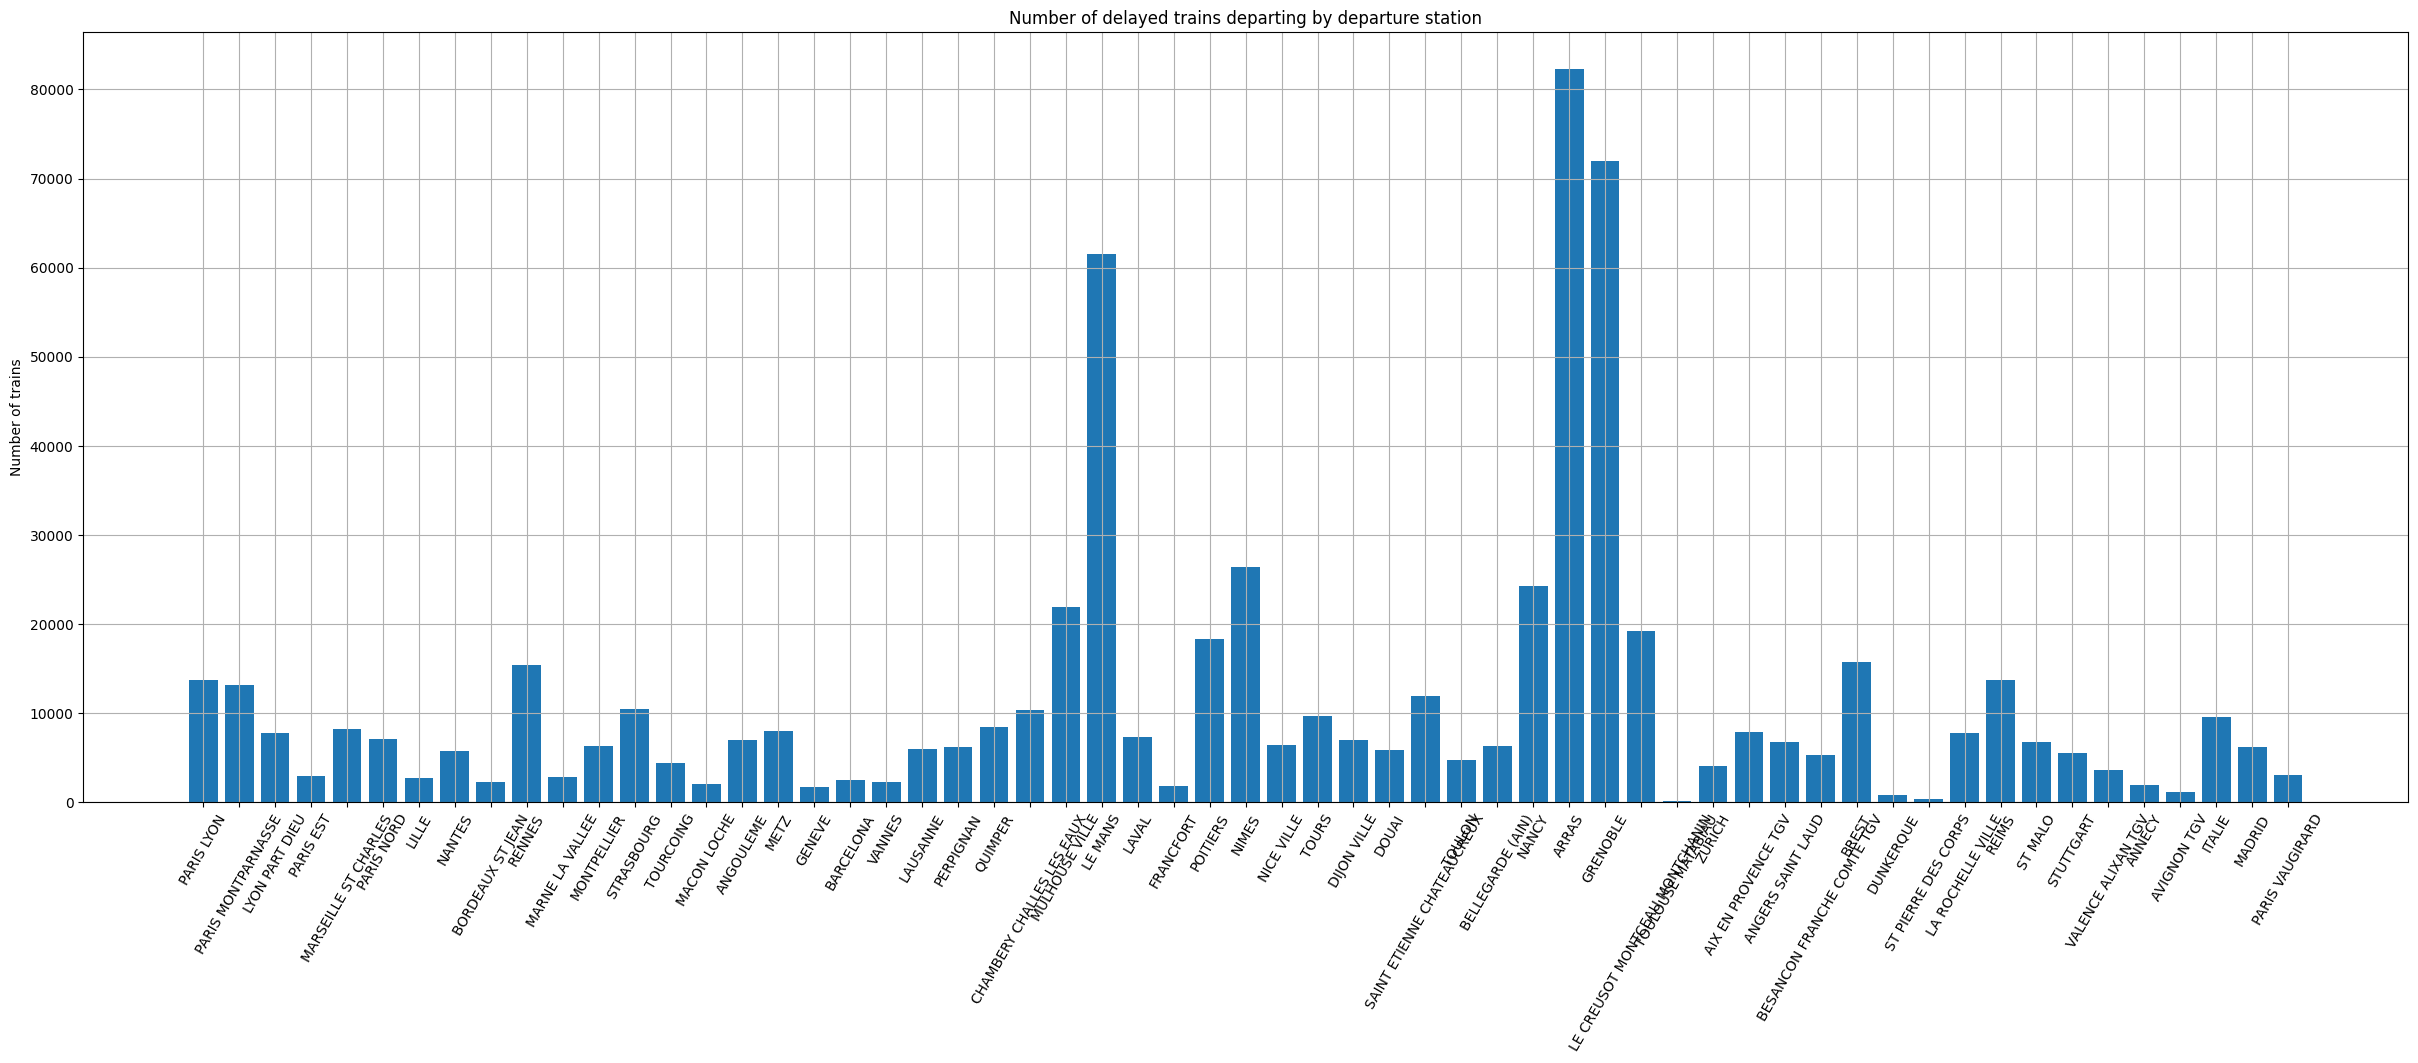

In [23]:
title = "Number of delayed trains departing by departure station"
delay_departure = df_clean.groupby("Departure station")[
    "Number of trains delayed at departure"
].sum()
display_bar_graph(delay_departure, good_stations, "x", title, (30, 10))

Number of trains **delayed or cancelled** at **arrival by station**

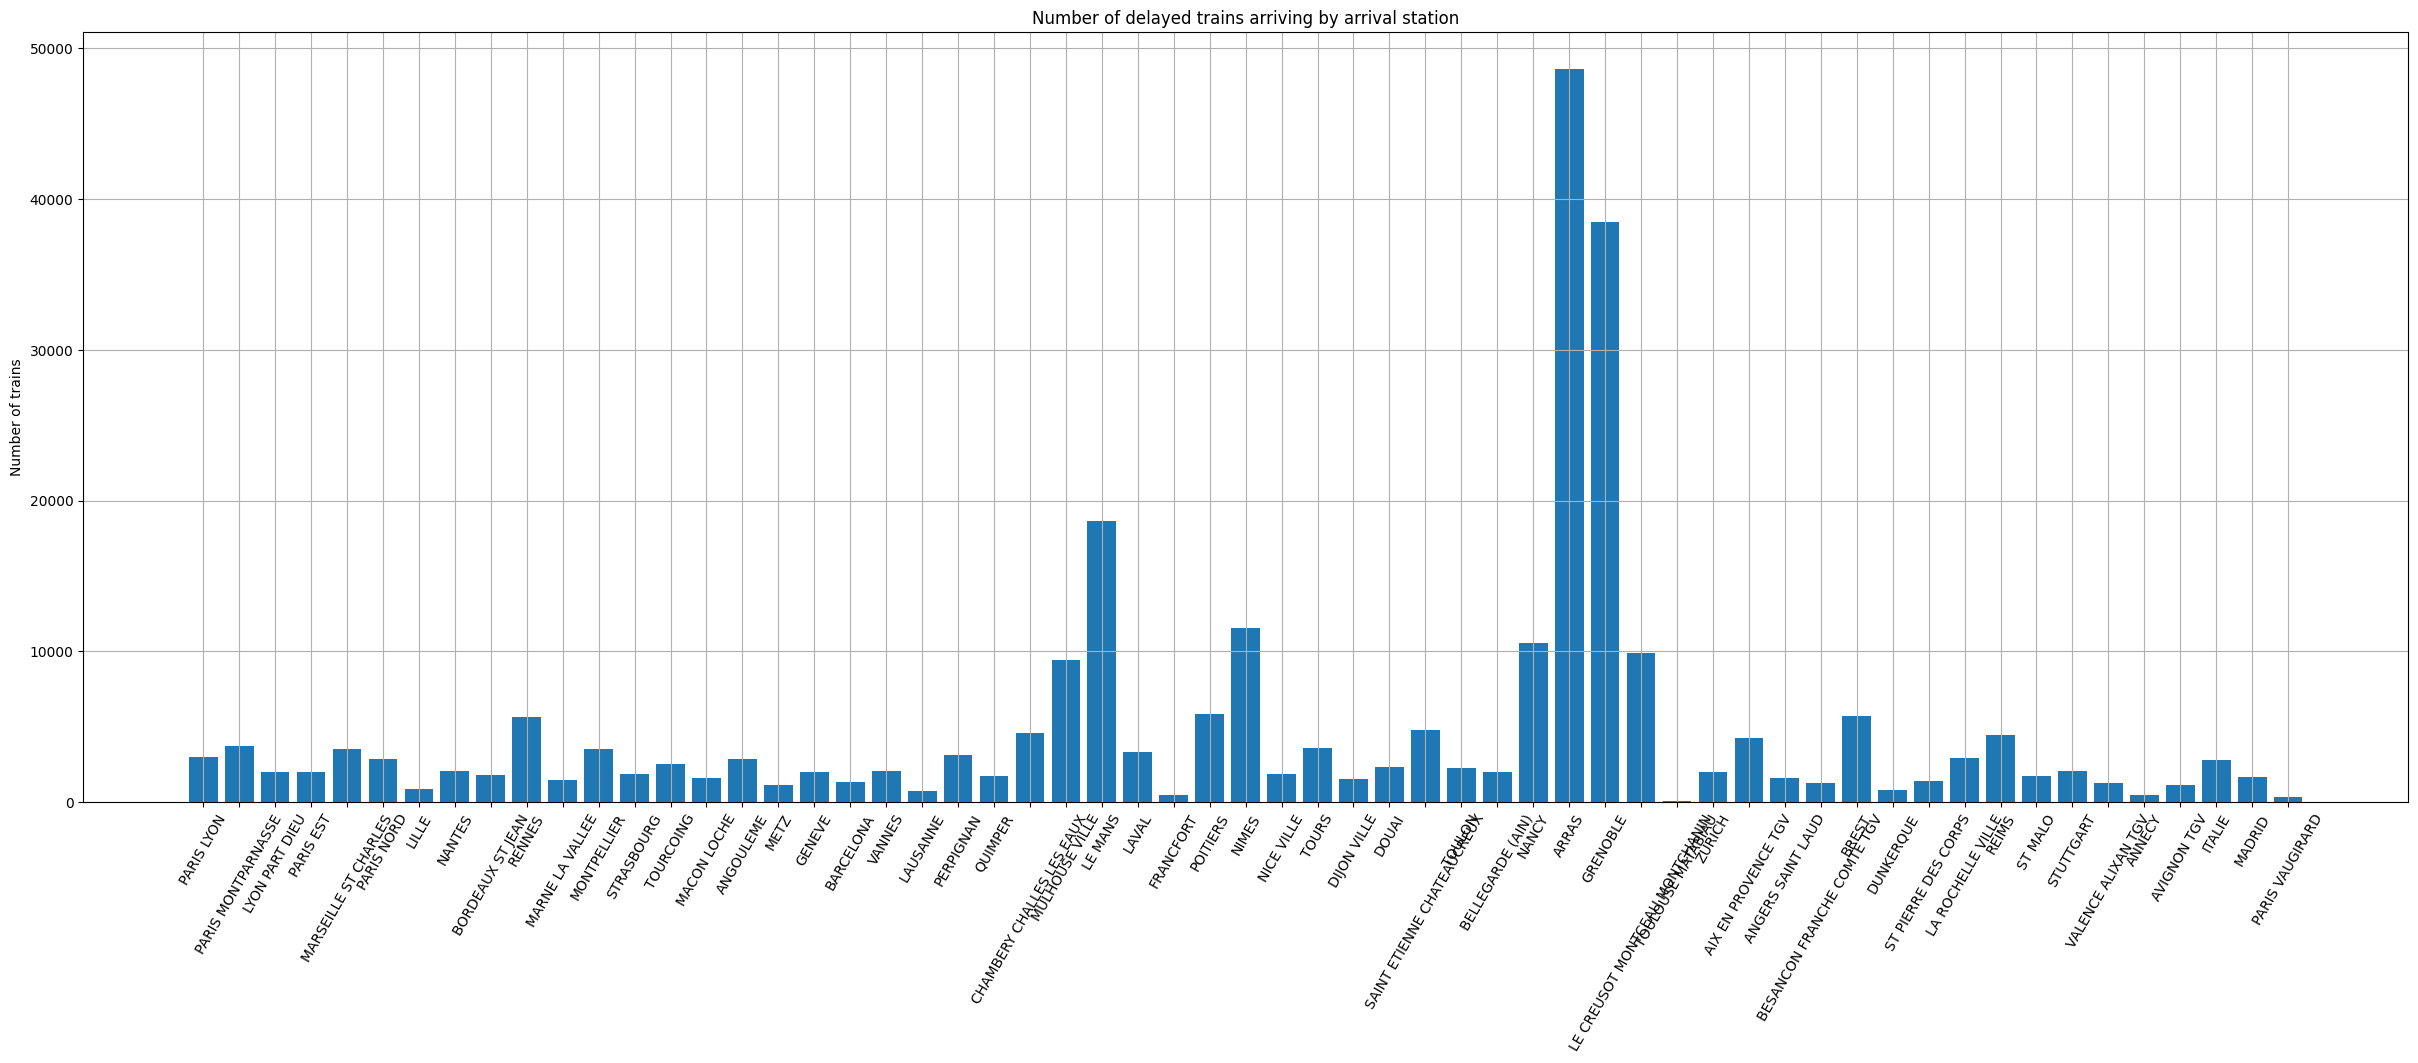

In [24]:
title = "Number of delayed trains arriving by arrival station"
delay_arrival = df_clean.groupby("Departure station")[
    "Number of trains delayed at arrival"
].sum()
display_bar_graph(delay_arrival, good_stations, "x", title, (30, 10))

Differences in **delayed/cancelled** trains by route **(National/International)**

/tmp/ipykernel_13703/3020274960.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("Service")["Number of trains delayed at departure"]


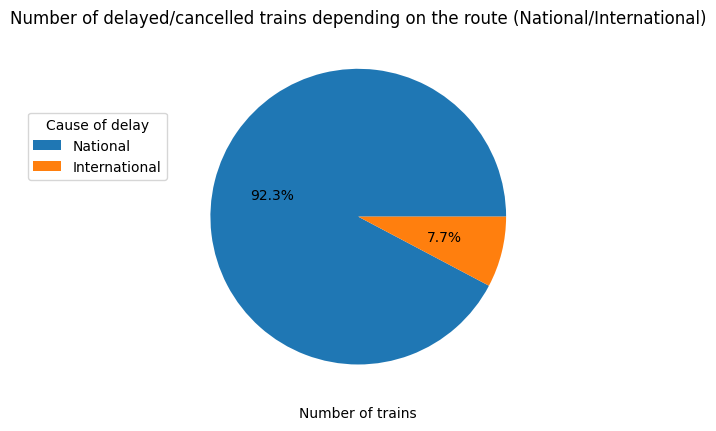

In [25]:
title = (
    "Number of delayed/cancelled trains depending on the route (National/International)"
)
labels = ["National", "International"]
services = (
    df_clean.groupby("Service")["Number of trains delayed at departure"]
    .sum()
    .reindex(["National", "International"])
)
display_pie_graph(services, labels, title)

Number of trains departing **on time by station**

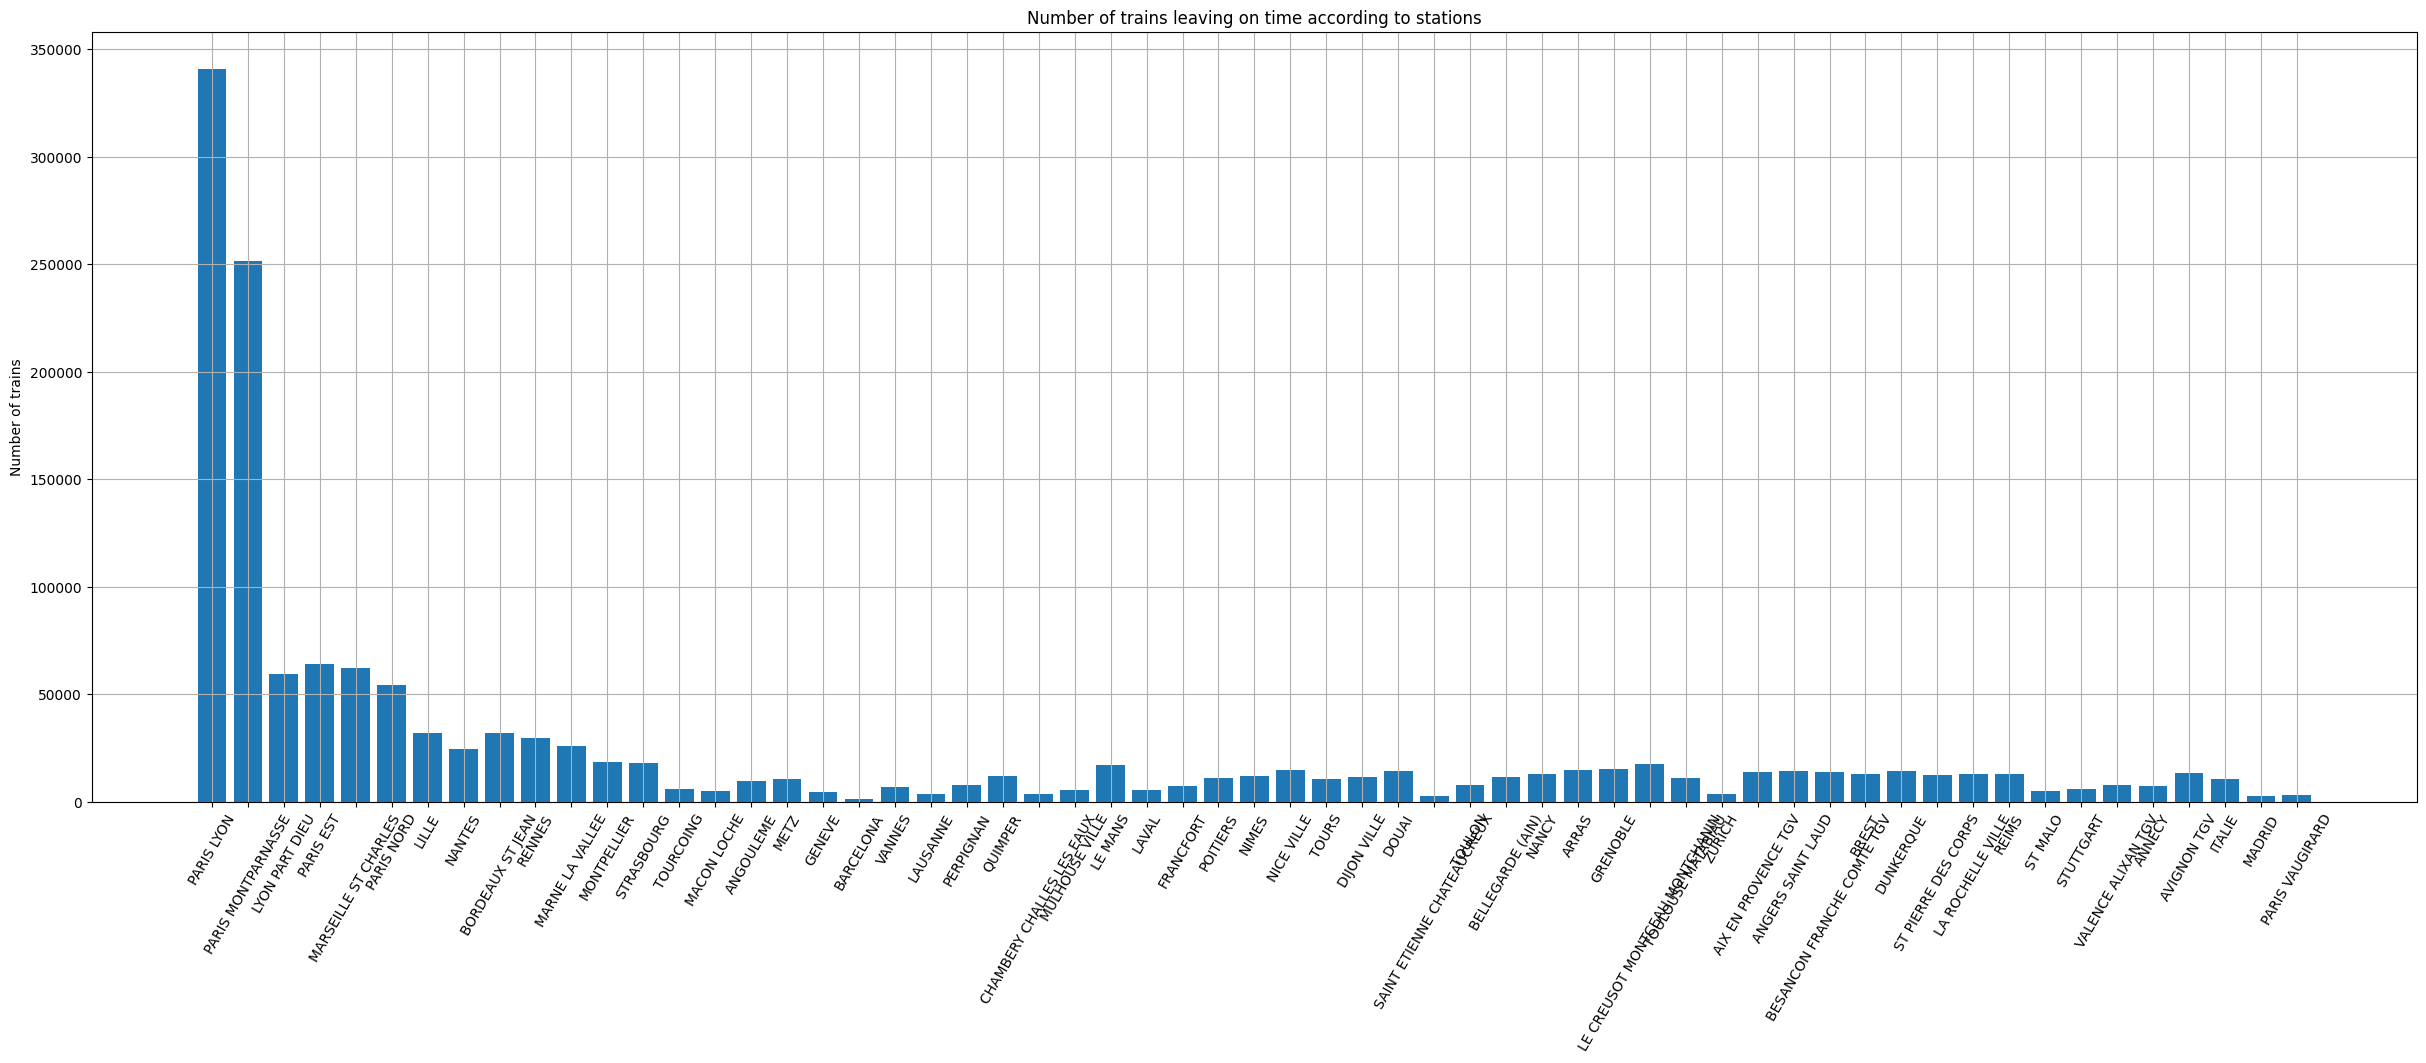

In [26]:
title = "Number of trains leaving on time according to stations"
labels = good_stations
df_clean = df_clean[
    (df_clean["Number of scheduled trains"] > 0)
    & (
        df_clean["Number of scheduled trains"]
        >= df_clean["Number of trains delayed at departure"]
    )
]
df_clean["on time"] = (
    df_clean["Number of scheduled trains"]
    - df_clean["Number of trains delayed at departure"]
)
nb_on_time = (
    df_clean.groupby("Departure station")["on time"].sum().reindex(good_stations)
)
display_bar_graph(nb_on_time, labels, "x", title, (30, 10))

**On-time vs delayed** train departures by station

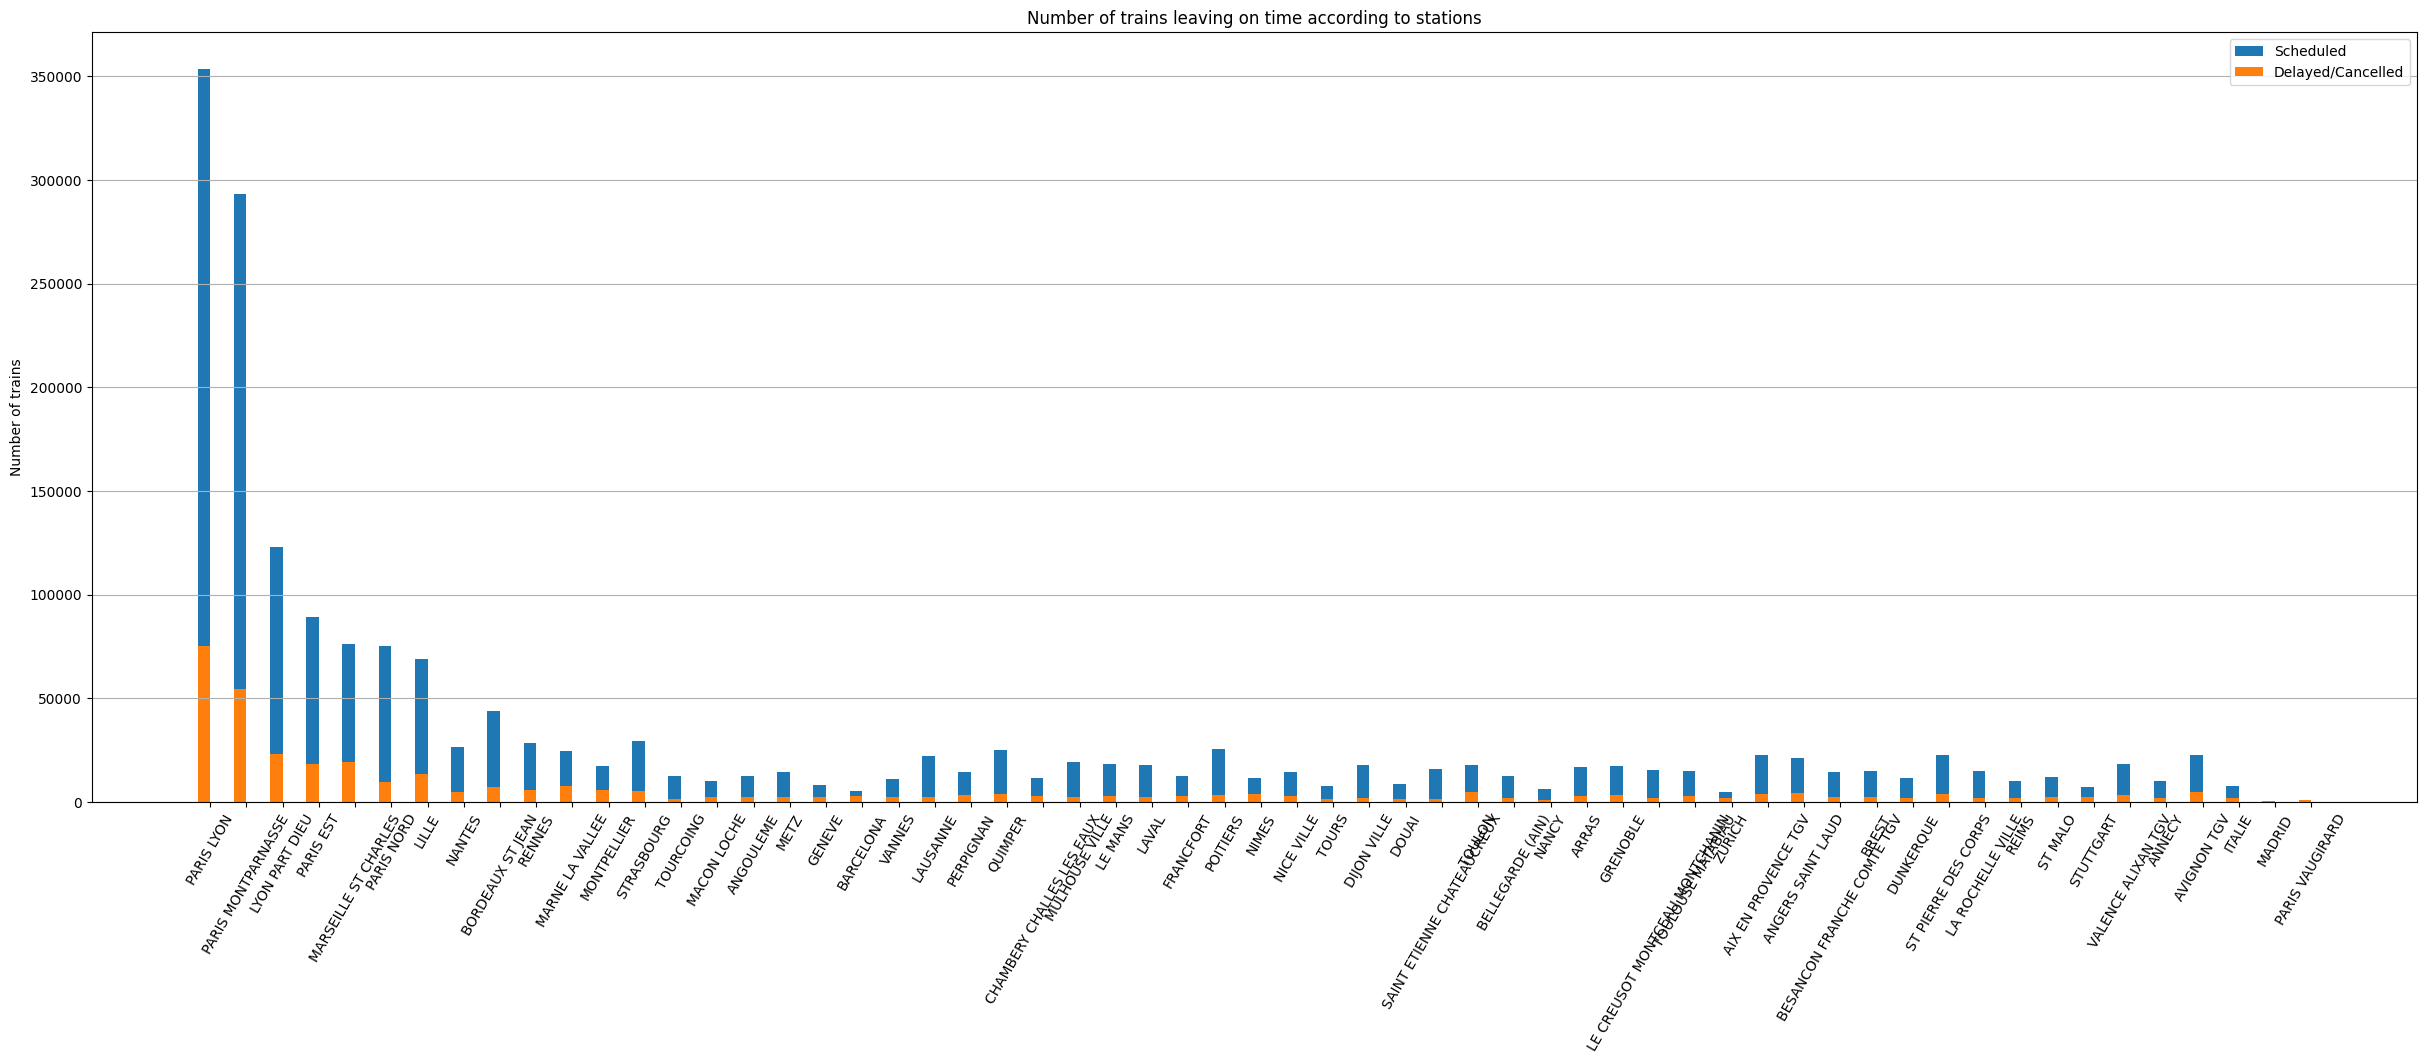

In [27]:
title = "Number of trains leaving on time according to stations"
delay = dict()
scheduled = dict()
for row in df_clean.values:
    nb_scheduled_trains = row[5]
    nb_trains_delay = row[6] + row[16] + row[18] + row[19]
    if pd.isna(nb_scheduled_trains) or pd.isna(nb_trains_delay) or pd.isna(row[3]):
        continue
    if str(row[3]) not in delay:
        delay[str(row[3])] = 0.0
    delay[str(row[3])] += nb_trains_delay
    if str(row[3]) not in scheduled:
        scheduled[str(row[3])] = 0.0
    scheduled[str(row[3])] += nb_scheduled_trains
lst1 = []
lst2 = []
for station in good_stations:
    lst1.append(scheduled[station])
    lst2.append(delay[station])
display_double_bar_graph(lst1, lst2, good_stations, "x", title, (30, 10))